# TVLA on the ASCAD database

Using the min-$p$ gradient as a performance measure.

In [1]:
import numpy as np

from src.data.traceloader import AscadRandomKey, TraceCategory
from src.tools.plotter import plot_accu
from src.tvla.accu import CSAccu

In [2]:
ascad = AscadRandomKey()

default = ascad.default.profile
random = ascad.random.profile

In [3]:
hw_1 = default.filter_by_hw(True)
hw_2 = default.filter_by_hw(False)

In [4]:
def randomize(traces_1, traces_2):
    trace_len = traces_1.shape[1]
    trace_num = min(len(traces_1), len(traces_2))

    shape = trace_num * 2, trace_len
    res = np.array((traces_1[:trace_num], traces_2[:trace_num])).reshape(shape)
    np.random.shuffle(res)

    return res[trace_num:], res[:trace_num]

In [5]:
hwr_1, hwr_2 = randomize(hw_1, hw_2)

In [6]:
import pickle as pkl
import os

def get_accu(trace_len, t1, t2, path):
    def dump(a, p):
        with open(p, 'wb') as f:
            pkl.dump(a, f)

    def load(p):
        with open(p, 'rb') as f:
            return pkl.load(f)

    if not os.path.exists(path):
        csa = CSAccu(trace_len)
        csa.add(t1, t2)
        dump(csa, path)

    return load(path)

In [7]:
def hw_less_4(traces, hamming_weights):
    ixs_less = np.where(hamming_weights < 4)[0]
    ixs_more = np.where(hamming_weights > 4)[0]

    return traces[ixs_less], traces[ixs_more]

def hw_eq_0(traces, hamming_weights):
    ixs_eq = np.where(hamming_weights == 0)[0]
    ixs_more = np.where(hamming_weights > 0)[0]

    return traces[ixs_eq], traces[ixs_more]

def split_hw(tc: TraceCategory, method):
    target_round = 0
    target_byte = 2

    hws = tc.hamming_weights[:, target_round, target_byte]
    return method(tc.traces, hws)

def balance(splits):
    min_len = min([len(s) for s in splits])
    return np.array([s[:min_len] for s in splits])

def a_vs_a(splits):
    a = splits[0].copy()
    np.random.shuffle(a)

    return balance(np.array_split(a, 2))

hw0 = get_accu(ascad.trace_len, *split_hw(default, hw_eq_0), "cache/hw0.pkl")
hw0_aa = get_accu(ascad.trace_len, *a_vs_a(split_hw(default, hw_eq_0)), "cache/hw0_aa.pkl")

In [8]:
hw4 = get_accu(ascad.trace_len, *split_hw(default, hw_less_4), "cache/hw4.pkl")
hw4_aa = get_accu(ascad.trace_len, *a_vs_a(split_hw(default, hw_less_4)), "cache/hw4_aa.pkl")

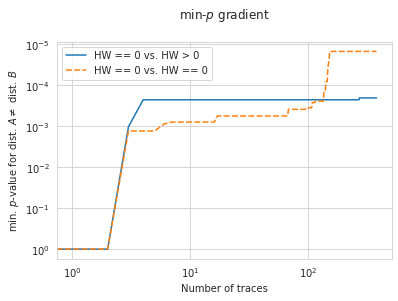

In [9]:
plot_accu({"HW == 0 vs. HW > 0": hw0, "HW == 0 vs. HW == 0": hw0_aa})

In [10]:
def split_bit(tc: TraceCategory, bit_ix=0):
    bits = tc.aes_r1b3[:, bit_ix].astype(bool)

    ix_0 = np.where(np.invert(bits))[0]
    ix_1 = np.where(bits)[0]

    return tc.traces[ix_0], tc.traces[ix_1]

bit_accu = {}
for b in range(0, 8):
    print(f"Calculating p-gradient for bit {b}...")
    name = f"b{b}"
    cache = f"cache/bit_wise/{name}"

    bit_accu[name] = get_accu(ascad.trace_len, *split_bit(default), f"{cache}.pkl")
    bit_accu[f"{name}_aa"] = get_accu(ascad.trace_len, *a_vs_a(split_bit(default)), f"{cache}_aa.pkl")

Calculating p-gradient for bit 0...
Calculating p-gradient for bit 1...
Calculating p-gradient for bit 2...
Calculating p-gradient for bit 3...
Calculating p-gradient for bit 4...
Calculating p-gradient for bit 5...
Calculating p-gradient for bit 6...
Calculating p-gradient for bit 7...


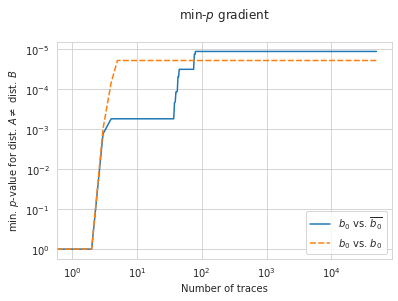

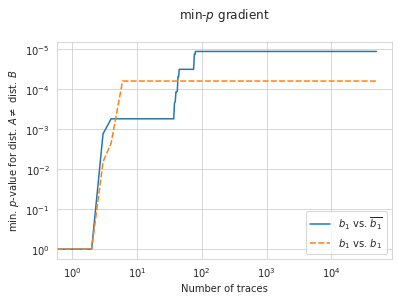

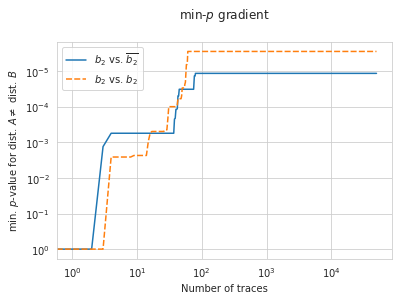

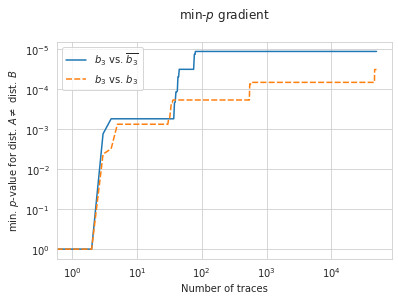

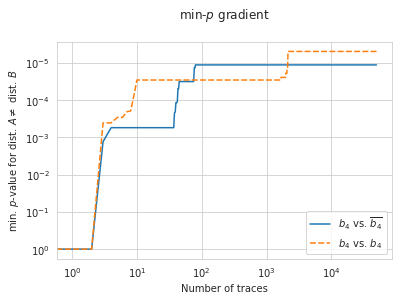

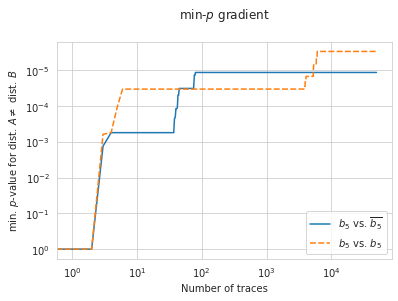

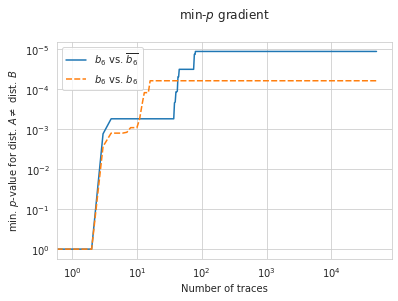

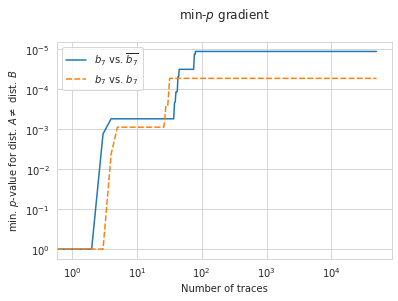

In [11]:
for b in range(0, 8):
    plot_accu({f"$b_{b}$ vs. $\overline{{b_{b}}}$": bit_accu[f"b{b}"], f"$b_{b}$ vs. $b_{b}$": bit_accu[f"b{b}_aa"]})

In [37]:
def pg_random_bit():
    p_gradients = []

    for _ in range(15):
        acc = CSAccu(ascad.trace_len)
        acc.add(*a_vs_a(split_bit(default)))
        p_gradients.append(acc.p_gradient)

    return p_gradients

pg_rb = pg_random_bit()

Performing t-tests (4 batches):   0%|          | 6/49834 [00:06<14:00:42,  1.01s/it]/home/berg/Documents/Afstudeer/LA/src/tvla/accu.py:28: RuntimeWarning: divide by zero encountered in true_divide
  t = m / s
/home/berg/Documents/Afstudeer/LA/src/tvla/accu.py:28: RuntimeWarning: invalid value encountered in true_divide
  t = m / s
/home/berg/Documents/Afstudeer/LA/src/tvla/accu.py:30: RuntimeWarning: invalid value encountered in true_divide
  dof = (var_a + var_b) ** 2 / ((var_a ** 2 + var_b ** 2) / nmm)
Performing t-tests (4 batches): 49842it [01:05, 763.75it/s]                            
Performing t-tests (4 batches): 49842it [01:04, 772.37it/s]                            
Performing t-tests (4 batches): 49842it [01:07, 737.14it/s]                            
Performing t-tests (4 batches): 49842it [01:06, 751.43it/s]                            
Performing t-tests (4 batches): 49842it [01:06, 752.09it/s]                            
Performing t-tests (4 batches): 49842it [01:05, 75

In [42]:
min(pg_rb[-2])

4.274624431963562e-06

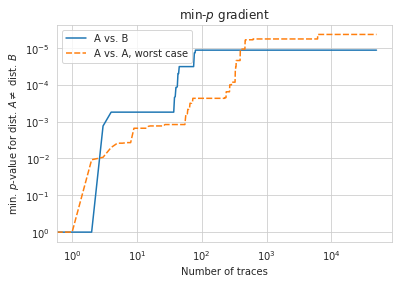

In [45]:
import seaborn as sns

g = sns.lineplot(data={"A vs. B": bit_accu["b0"].p_gradient[:len(pg_rb[0])], "A vs. A, worst case": pg_rb[-2]})
g.set(xscale="log", yscale="log", ylabel="min. $p$-value for dist. $A \\neq$ dist. $B$", xlabel="Number of traces",
          title=f"min-$p$ gradient")

g.invert_yaxis()

Performing t-tests (2 batches):   1%|          | 5/765 [00:00<00:30, 24.60it/s]/home/berg/Documents/Afstudeer/LA/src/tvla/accu.py:28: RuntimeWarning: divide by zero encountered in true_divide
  t = m / s
/home/berg/Documents/Afstudeer/LA/src/tvla/accu.py:28: RuntimeWarning: invalid value encountered in true_divide
  t = m / s
/home/berg/Documents/Afstudeer/LA/src/tvla/accu.py:30: RuntimeWarning: invalid value encountered in true_divide
  dof = (var_a + var_b) ** 2 / ((var_a ** 2 + var_b ** 2) / nmm)
Performing t-tests (2 batches): 100%|██████████| 385/385 [00:00<00:00, 783.80it/s]


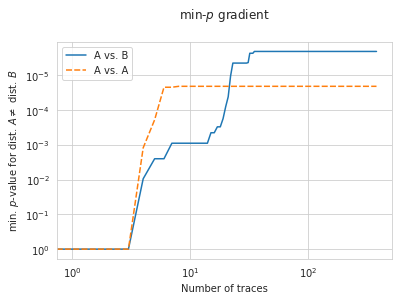

In [12]:
def split_key(tc: TraceCategory, key_a=0, key_b=1):
    ix_a = np.where(tc.labels == key_a)[0]
    ix_b = np.where(tc.labels == key_b)[0]

    return tc.traces[ix_a], tc.traces[ix_b]

key = CSAccu(ascad.trace_len)
key.add(*balance(split_key(default)))

key_aa = CSAccu(ascad.trace_len)
key_aa.add(*a_vs_a(split_key(default)))

plot_accu({"A vs. B": key, "A vs. A": key_aa})

In [13]:
def pg_random():
    p_gradients = []

    for _ in range(50):
        acc = CSAccu(ascad.trace_len)
        acc.add(*a_vs_a(split_key(default)))
        p_gradients.append(acc.p_gradient)

    return p_gradients

pgr = pg_random()

Performing t-tests (2 batches):   1%|▏         | 5/385 [00:00<00:07, 48.61it/s]/home/berg/Documents/Afstudeer/LA/src/tvla/accu.py:28: RuntimeWarning: divide by zero encountered in true_divide
  t = m / s
/home/berg/Documents/Afstudeer/LA/src/tvla/accu.py:28: RuntimeWarning: invalid value encountered in true_divide
  t = m / s
/home/berg/Documents/Afstudeer/LA/src/tvla/accu.py:30: RuntimeWarning: invalid value encountered in true_divide
  dof = (var_a + var_b) ** 2 / ((var_a ** 2 + var_b ** 2) / nmm)
Performing t-tests (2 batches): 100%|██████████| 385/385 [00:00<00:00, 806.15it/s]


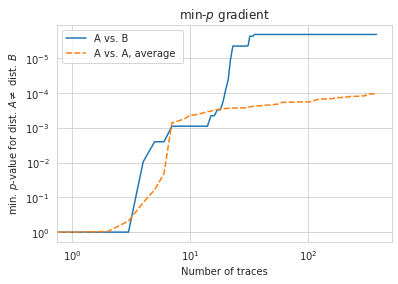

In [36]:
import seaborn as sns

g = sns.lineplot(data={"A vs. B": key.p_gradient[:len(pgr[0])], "A vs. A, average ": np.mean(pgr, axis=0)})
g.set(xscale="log", yscale="log", ylabel="min. $p$-value for dist. $A \\neq$ dist. $B$", xlabel="Number of traces",
          title=f"min-$p$ gradient")

g.invert_yaxis()